## Exercise 3

In [96]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (11.7,8.27)})

In [110]:
import warnings

In [78]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [6]:
np.random.seed(11148705)

In [13]:
phi_one = 1.1
phi_two = -0.3
theta = 0.6

ar_p = np.array([phi_one, phi_two])
ma_p = np.array([theta])

make_arma_process = lambda ar, ma: sm.tsa.ArmaProcess(np.r_[1, -ar],np.r_[1, ma]) 

The model,

\begin{align}
    X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \epsilon_t + \theta \epsilon_{t-1}
\end{align}

can be rewritten as

\begin{align}
    X_t = \phi X_{t-1} +  \epsilon_t
\end{align}

In [57]:
def make_data_generator(ar_params, ma_params):
    arma_process = make_arma_process(ar_params, ma_params)
    
    if not arma_process.isstationary:
        raise ValueError('Process is not stationary')
        
    if not arma_process.isinvertible:
        raise ValueError('Process is not invertible')
                    
    return arma_process.generate_sample

In [58]:
gen_X = make_data_generator(ar_p, ma_p)

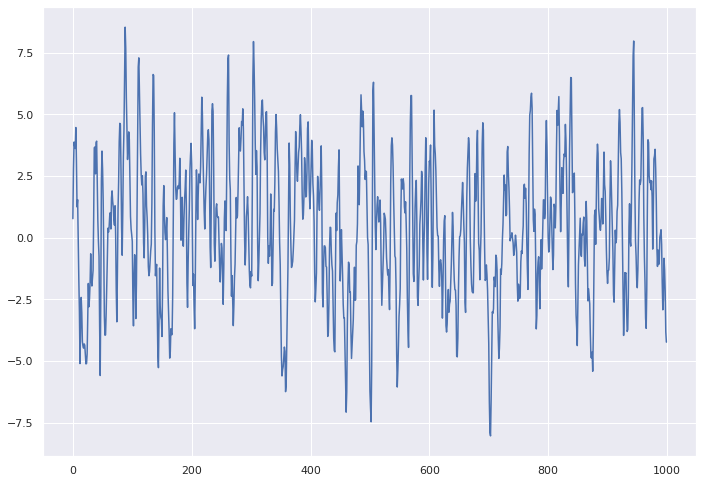

In [119]:
sns.lineplot(data = gen_X(1_000))
plt.show()

In [111]:
def estimate(n):
    
    X = gen_X(n)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = sm.tsa.ARMA(X, (2, 1)).fit(trend='nc', disp=0)
    
    return model.params

In [112]:
def monte_carlo_estimation(n, b, estimator, jobs = 1):
    
    iterations = (n for _ in range(b))
    
    jobs = jobs if jobs > 0 else mp.cpu_count()
    
    with mp.Pool(jobs) as p:
        estimated_params = p.map(estimator, iterations)
        
    return np.array(estimated_params)

In [113]:
%%time
%%notify

estimated_params = monte_carlo_estimation(500, 10_000, estimate, jobs=-1)

<IPython.core.display.Javascript object>

CPU times: user 266 ms, sys: 812 ms, total: 1.08 s
Wall time: 11min 25s


In [114]:
param_df = pd.DataFrame(estimated_params, columns=['phi_1', 'phi_2', 'theta'])

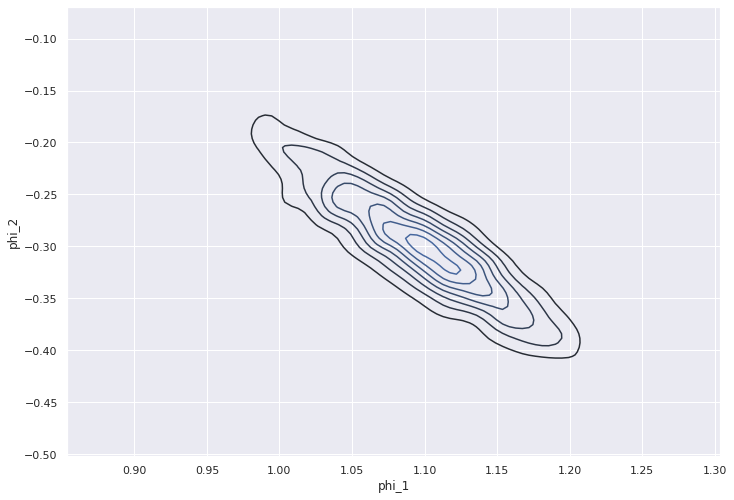

In [115]:
sns.kdeplot(param_df['phi_1'], param_df['phi_2'])
plt.show()

In [118]:
param_df.corr()

,phi_1,phi_2,theta
phi_1,1.000000,-0.912919,-0.671106
phi_2,-0.912919,1.000000,0.646636
theta,-0.671106,0.646636,1.000000


### Correct values

In [122]:
phi_one = 0.66
phi_two = -0.5
theta = 0.36

ar_p = np.array([phi_one, phi_two])
ma_p = np.array([theta])

gen_X_identified = make_data_generator(ar_p, ma_p)

In [123]:
def estimate_ident(n):
    
    X = gen_X_identified(n)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = sm.tsa.ARMA(X, (2, 1)).fit(trend='nc', disp=0)
    
    return model.params

In [127]:
%%notify
%%time

estimated_params = monte_carlo_estimation(500, 10_000, estimate_ident, jobs=2)

CPU times: user 141 ms, sys: 297 ms, total: 438 ms
Wall time: 14min 31s


<IPython.core.display.Javascript object>

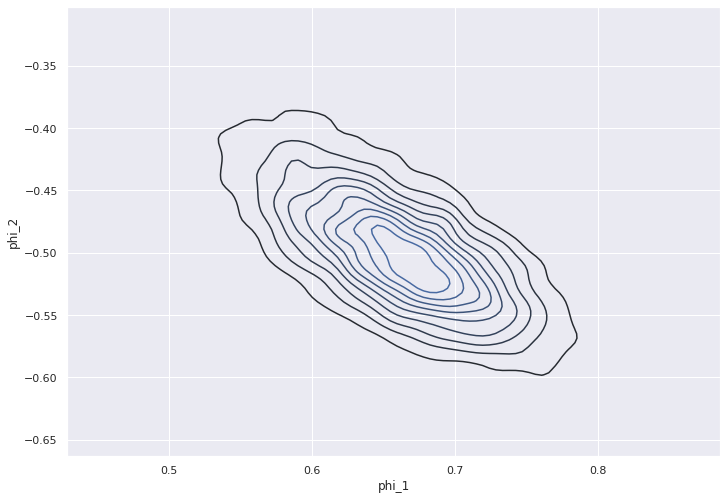

,phi_1,phi_2,theta
phi_1,1.000000,-0.694101,-0.752680
phi_2,-0.694101,1.000000,0.614518
theta,-0.752680,0.614518,1.000000


In [128]:
param_df = pd.DataFrame(estimated_params, columns=['phi_1', 'phi_2', 'theta'])
sns.kdeplot(param_df['phi_1'], param_df['phi_2'])
plt.show()

param_df.corr()